### Description: Computes GSA sensitvity indices using PCE surrogate construction using projection (Gaussian Quadrature)
#### Additional packages required: [UQTk](www.sandia.gov)

###### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com

This code deals with computing Sobol sensitivity indices using PCE surrogate. The coefficeints of the PCE surrogate are computed using the projection approach. The model considered for this code is:
$$Y = \prod_{i=1}^k g_i(X_i), \;\;\text{   where   } \;\;g_i(X_i) = \frac{|4X_i - 2| + a_i}{1 + a_i},$$
where each input is distributed as uniform(0,1) and parameters $a_i$ are known constants. 

In [1]:
#!/usr/bin/python
from numpy import *
import matplotlib.pyplot as plt
import os
import math
import sys

Defines the function and the input distribution for the give case:

In [2]:
def Sobolg(x):
    dim = 8
    a = [1.0,2.0,5.0,10.0,20.0,50.0,100.0,500.0]
    PdfType = ['u','u','u','u','u','u','u','u']
    Xpar = zeros((dim,2))
    SI = zeros((2,dim))
    vari = zeros((2,dim))
    vary = 1.0
    for ii in range(0,dim):
        Xpar[ii,1] = 1.0
        vari[0,ii] = 1/(3*(1+a[ii])**2)
        vary = vary*(vari[0,ii]+1)
    vary = vary-1
    SI = vari/vary
    SI[1,:] = [0.6342,0.2945,0.0756,0.0227,0.0062,0.0011,0.0003,0.0000]
    label = [r'$X_1$',r'$X_2$',r'$X_3$',r'$X_4$',r'$X_5$',r'$X_6$',r'$X_7$',r'$X_8$']
    if isinstance(x,int):
        return dim,PdfType,Xpar,SI,label
    else: 
        y = 1.0
        for i in range(0,dim):
            y = y*(abs(4*x[:,i]-2)+a[i])/(1+a[i])
        return y

PCE Projection/Quadrature set up (UQTk quadrature type options: 'LU', 'HG', 'CC', 'CCO', 'NC', 'NCO'):

In [3]:
f  = Sobolg # name of model (defined above)
PCtype = 'LU' # type of PC basis
p  = 2 # order of PCE expansion

In [4]:
Qtype  = 'LU' # type of quadrature
Qstype = 'sparse'# sparse or tensor grid
Qlvl   = 5 #level of quadrature
outLog = ' >> out.log'
set_printoptions(precision=3,suppress=True)
plotPdf =1

Extract model/parameter info and print it:

In [5]:
d,Xpdftype,Xpdfpar,SI,Xlabel = f(0)
SIest = zeros((2,d))
SIerr = zeros((2,d))
os.system('rm *.dat data/* *.pyc'+outLog)
print('Dimension : ', d)
for i in range(0,d):
    print('Parameter : ', Xlabel[i],Xpdftype[i],Xpdfpar[i,:])

Dimension :  8
Parameter :  $X_1$ u [0. 1.]
Parameter :  $X_2$ u [0. 1.]
Parameter :  $X_3$ u [0. 1.]
Parameter :  $X_4$ u [0. 1.]
Parameter :  $X_5$ u [0. 1.]
Parameter :  $X_6$ u [0. 1.]
Parameter :  $X_7$ u [0. 1.]
Parameter :  $X_8$ u [0. 1.]


Generate quadrature points using UQtk (outputs into a file) and load them, and then convert them into points from given nonstandard distribution:

In [6]:
CMD = 'generate_quad -g '+Qtype+' -p '+str(Qlvl)+' -d '+str(d)+' -x '+Qstype
os.system(CMD+outLog)
Xwts = loadtxt('wghts.dat')
Xpts = zeros((len(Xwts),d))
Xpts_std = loadtxt('qdpts.dat')

In [7]:
for i in range(0,d):
    if Xpdftype[i] == 'u':
        if d==1:
            Xpts[:,i] = 0.5*(Xpdfpar[i,0] + Xpdfpar[i,1]) + 0.5*(Xpdfpar[i,1] - Xpdfpar[i,0])*Xpts_std
        else:
            Xpts[:,i] = 0.5*(Xpdfpar[i,0] + Xpdfpar[i,1]) + 0.5*(Xpdfpar[i,1] - Xpdfpar[i,0])*Xpts_std[:,i]
    elif Xpdftype[i] == 'n':
        Xpts[:,i] = Xpdfpar[i,0] + sqrt(Xpdfpar[i,1])*Xpts_std[:,i]
Yvals = f(Xpts)
savetxt('ydata.dat',Yvals)

Computes PCE coefficients, read then from file, compute L2 norm, and print the results:

In [8]:
CMD = 'pce_resp -e -x '+PCtype+' -d'+str(d)+' -o'+str(p)
os.system(CMD+outLog)
PCcoeff = loadtxt('PCcoeff_quad.dat')
PCmindex = loadtxt('mindex.dat')
Ypc =loadtxt('ydata_pc.dat')
L2norm = linalg.norm(multiply(sqrt(abs(Xwts)),Yvals - Ypc),2)
PCtermsNZ = sum(1 for i in PCcoeff if abs(i) > 1e-05)

In [9]:
print('PCE type   : ',PCtype,'\nPCE Dim    : ',d,'\nPCE Order  : ',p,'\n# PCE terms: ',len(PCcoeff))
print('-------------------')
print('Quad type  : ',Qtype,'\nSparse grd?: ',Qstype,'\nQuad Level : ',Qlvl,'\n#  qpoints : ',Xpts.shape[0])
print('-------------------')
print('Non-zero PCE coeffs: (',PCtermsNZ,'/', len(PCcoeff),')')
for i,mi in enumerate(PCmindex):
    if abs(PCcoeff[i]) > 1e-05:
        print('{:5d}'.format(i),' : ', mi.astype(int),' : ', '{:8.3f}'.format(PCcoeff[i]))
print('-------------------')
print('L2 Error   : ', L2norm)
os.system('mv ydata.dat ydata_qdpts.dat')
os.system('mv ydata_pc.dat ydata_qdpts_pc.dat');

PCE type   :  LU 
PCE Dim    :  8 
PCE Order  :  2 
# PCE terms:  45
-------------------
Quad type  :  LU 
Sparse grd?:  sparse 
Quad Level :  5 
#  qpoints :  31745
-------------------
Non-zero PCE coeffs: ( 9 / 45 )
    0  :  [0 0 0 0 0 0 0 0]  :     0.989
    9  :  [2 0 0 0 0 0 0 0]  :     0.624
   17  :  [0 2 0 0 0 0 0 0]  :     0.409
   24  :  [0 0 2 0 0 0 0 0]  :     0.187
   30  :  [0 0 0 2 0 0 0 0]  :     0.084
   35  :  [0 0 0 0 2 0 0 0]  :     0.025
   39  :  [0 0 0 0 0 2 0 0]  :    -0.014
   42  :  [0 0 0 0 0 0 2 0]  :    -0.028
   44  :  [0 0 0 0 0 0 0 2]  :    -0.039
-------------------
L2 Error   :  6.956155770534226


Compute sensitvity indices using PCE coefficients and print the estimated vs analytical SI values:


S_i  (Ex.):  [0.604 0.268 0.067 0.02  0.005 0.001 0.    0.   ] 
S_Ti (Ex.):  [0.634 0.294 0.076 0.023 0.006 0.001 0.    0.   ]
S_i  (PCE):  [0.647 0.277 0.058 0.012 0.001 0.    0.001 0.003] 
S_Ti (PCE):  [0.647 0.277 0.058 0.012 0.001 0.    0.001 0.003]
S_i (err%):  [ 7.217  3.337 12.963 40.739  0.     0.     0.     0.   ] 
S_Ti(err%):  [ 2.068  5.845 22.768 47.895  0.     0.     0.     0.   ]


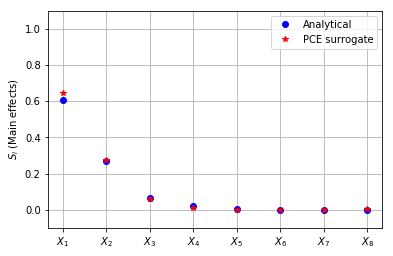

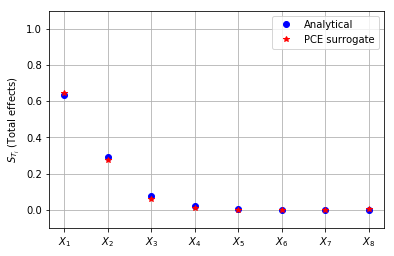

In [10]:
if d > 1:
    CMD = 'pce_sens -m mindex.dat -f PCcoeff_quad.dat -x'+PCtype
    os.system(CMD+outLog)
    SIest[0,:] = loadtxt('mainsens.dat')
    SIest[1,:] = loadtxt('totsens.dat')
    for i in range(0,d):
        for ii in range(0,2):
            if SI[ii,i] > 1e-02: 
                SIerr[ii,i] = 100*abs(SIest[ii,i] - SI[ii,i])/SI[ii,i]
            else:
                SIerr[ii,i] = 0.0 
    print('\nS_i  (Ex.): ', SI[0,:],'\nS_Ti (Ex.): ', SI[1,:])
    print('S_i  (PCE): ', SIest[0,:],'\nS_Ti (PCE): ', SIest[1,:])
    print('S_i (err%): ', SIerr[0,:],'\nS_Ti(err%): ', SIerr[1,:])
    fig = plt.figure(1)
    x =range(1,d+1)
    plt.plot(x,SI[0,:],'bo',label='Analytical')
    plt.plot(x,SIest[0,:],'r*',label='PCE surrogate')
    plt.grid(True)
    plt.ylim(-0.1,1.1)
    plt.ylabel(r'$S_i$ (Main effects)')
    plt.legend(loc='best', numpoints = 1)
    plt.xticks(x,Xlabel)
    plt.savefig('GSA_PCE_foSI.pdf',bbox_inches='tight')
    fig = plt.figure(2)
    x =range(1,d+1)
    plt.plot(x,SI[1,:],'bo',label='Analytical')
    plt.plot(x,SIest[1,:],'r*',label='PCE surrogate')
    plt.grid(True)
    plt.ylim(-0.1,1.1)
    plt.legend(loc='best', numpoints = 1)
    plt.ylabel(r'$S_{T_i}$ (Total effects)')
    plt.xticks(x,Xlabel)
    plt.savefig('GSA_PCE_toSI.pdf',bbox_inches='tight')

Plotting the true vs PCE surrogate pdf of the output Y, this checks for goodness of PCE surrogate, along with L2 error above:  

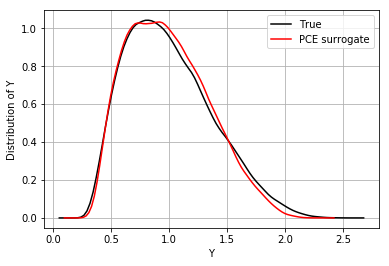

In [11]:
if plotPdf == 1:
    M = 100000
    Xspls = zeros((M,d))
    Xspls_std = zeros((M,d))
    for i in range(0,d):
        RndSeed = 100+i
        if (Xpdftype[i] == 'u'):
            CMD1 = 'trdSpls -a -1 -b 1 -n '+str(M)+' -i '+str(RndSeed)+' -f spls.dat -t u'
            os.system(CMD1)
            Xstd = loadtxt('spls.dat')
            Xnew = 0.5*(Xpdfpar[i,0] + Xpdfpar[i,1]) + 0.5*(Xpdfpar[i,1] - Xpdfpar[i,0])*Xstd
        elif (Xpdftype[i] == 'n'):
            CMD1 = 'trdSpls -a '+str(-100000)+' -b '+str(100000) \
                    +' -m 0 -s 1 -n '+str(M)+' -i '+str(RndSeed)+' -f spls.dat  -t n'
            os.system(CMD1)
            Xstd = loadtxt('spls.dat')
            Xnew = Xpdfpar[i,0] + sqrt(Xpdfpar[i,1])*Xstd
        Xspls[:,i] = Xnew
        Xspls_std[:,i] = Xstd
    os.system('rm spls.dat')
    Ymc = f(Xspls)
    savetxt('ydata_mc.dat',Ymc)
    savetxt('xdata.dat',Xspls_std)
    CMD6 = 'pdf_cl -i ydata_mc.dat'
    os.system(CMD6)
    YmcDens = loadtxt('dens.dat')
    CMD7 = 'pce_eval -x PC_mi -f PCcoeff_quad.dat -o '+str(p)+' -s '+PCtype
    os.system(CMD7+outLog)
    os.system('mv ydata.dat ydata_mc_pc.dat')
    CMD8 = 'pdf_cl -i ydata_mc_pc.dat'
    os.system(CMD8)
    YmcpcDens = loadtxt('dens.dat')
    fig = plt.figure(3)
    plt.plot(YmcDens[:,0],YmcDens[:,1],'k-',label='True')
    plt.plot(YmcpcDens[:,0],YmcpcDens[:,1],'r-',label='PCE surrogate')
    plt.grid(True)
    plt.legend(loc='best', numpoints = 1)
    plt.ylabel('Distribution of Y')
    plt.xlabel('Y')
    plt.savefig('GSA_PCE_projection_ydens.pdf',bbox_inches='tight')